In [1]:
import math
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

#modified from https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbE1tTmt3ajl2V2NPNnl2ODV2MTV6Q1Z3eE9PQXxBQ3Jtc0tuOWNkVTVvNmdwNFBLZ2syYkZHZl9FM3FkWnFtRFFaY3BNMHNsUURNbFVicVhvYWdaYkQzN3JCajczTHl2RkRQQUxHNlNTUlF5RFJiajA3ZzRiQW9QOUZsVEN4anZwUWV3ZGhxM0xXVVlqZ0lOLVZ0QQ&q=https%3A%2F%2Fcolab.research.google.com%2Fgithub%2Ffuturemojo%2Fnlp-demystified%2Fblob%2Fmain%2Fnotebooks%2Fnlpdemystified_transformers_and_pretraining.ipynb&v=acxqoltilME
#video https://youtu.be/acxqoltilME?si=LCrFUF0CUv63nYSV

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
#device = "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
def scaled_dot_product_attention(query, key, value, mask=None):
    #shapes are batch size, num heads, seq length, depth
    key_dim = key.size(1)
    scaled_scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(key_dim)  
    if mask is not None:
        scaled_scores = scaled_scores.masked_fill(mask==0, float("-inf"))
    softmax = F.softmax
    #if its B, H, s_q, s_k
    #softmax over s_k
    weights = softmax(scaled_scores, dim = -1) 
    return torch.matmul(weights, value), weights

In [23]:
seq_len = 3
embed_dim = 4

queries = torch.rand(seq_len, embed_dim).to(device)
keys = torch.rand(seq_len, embed_dim).to(device)
values = torch.rand(seq_len, embed_dim).to(device)

print("Queries:\n", queries)

Queries:
 tensor([[0.5666, 0.7757, 0.3103, 0.7989],
        [0.7397, 0.0313, 0.5390, 0.0108],
        [0.1817, 0.0236, 0.1933, 0.0715]], device='cuda:0')


In [24]:
output, attn_weights = scaled_dot_product_attention(queries, keys, values)

print("Output\n", output, "\n")
print("Weights\n", attn_weights)

Output
 tensor([[0.3608, 0.4415, 0.5928, 0.3009],
        [0.3681, 0.4674, 0.6008, 0.3019],
        [0.3743, 0.4830, 0.6119, 0.3084]], device='cuda:0') 

Weights
 tensor([[0.4175, 0.2817, 0.3009],
        [0.3809, 0.2939, 0.3251],
        [0.3516, 0.3204, 0.3280]], device='cuda:0')


for refrence
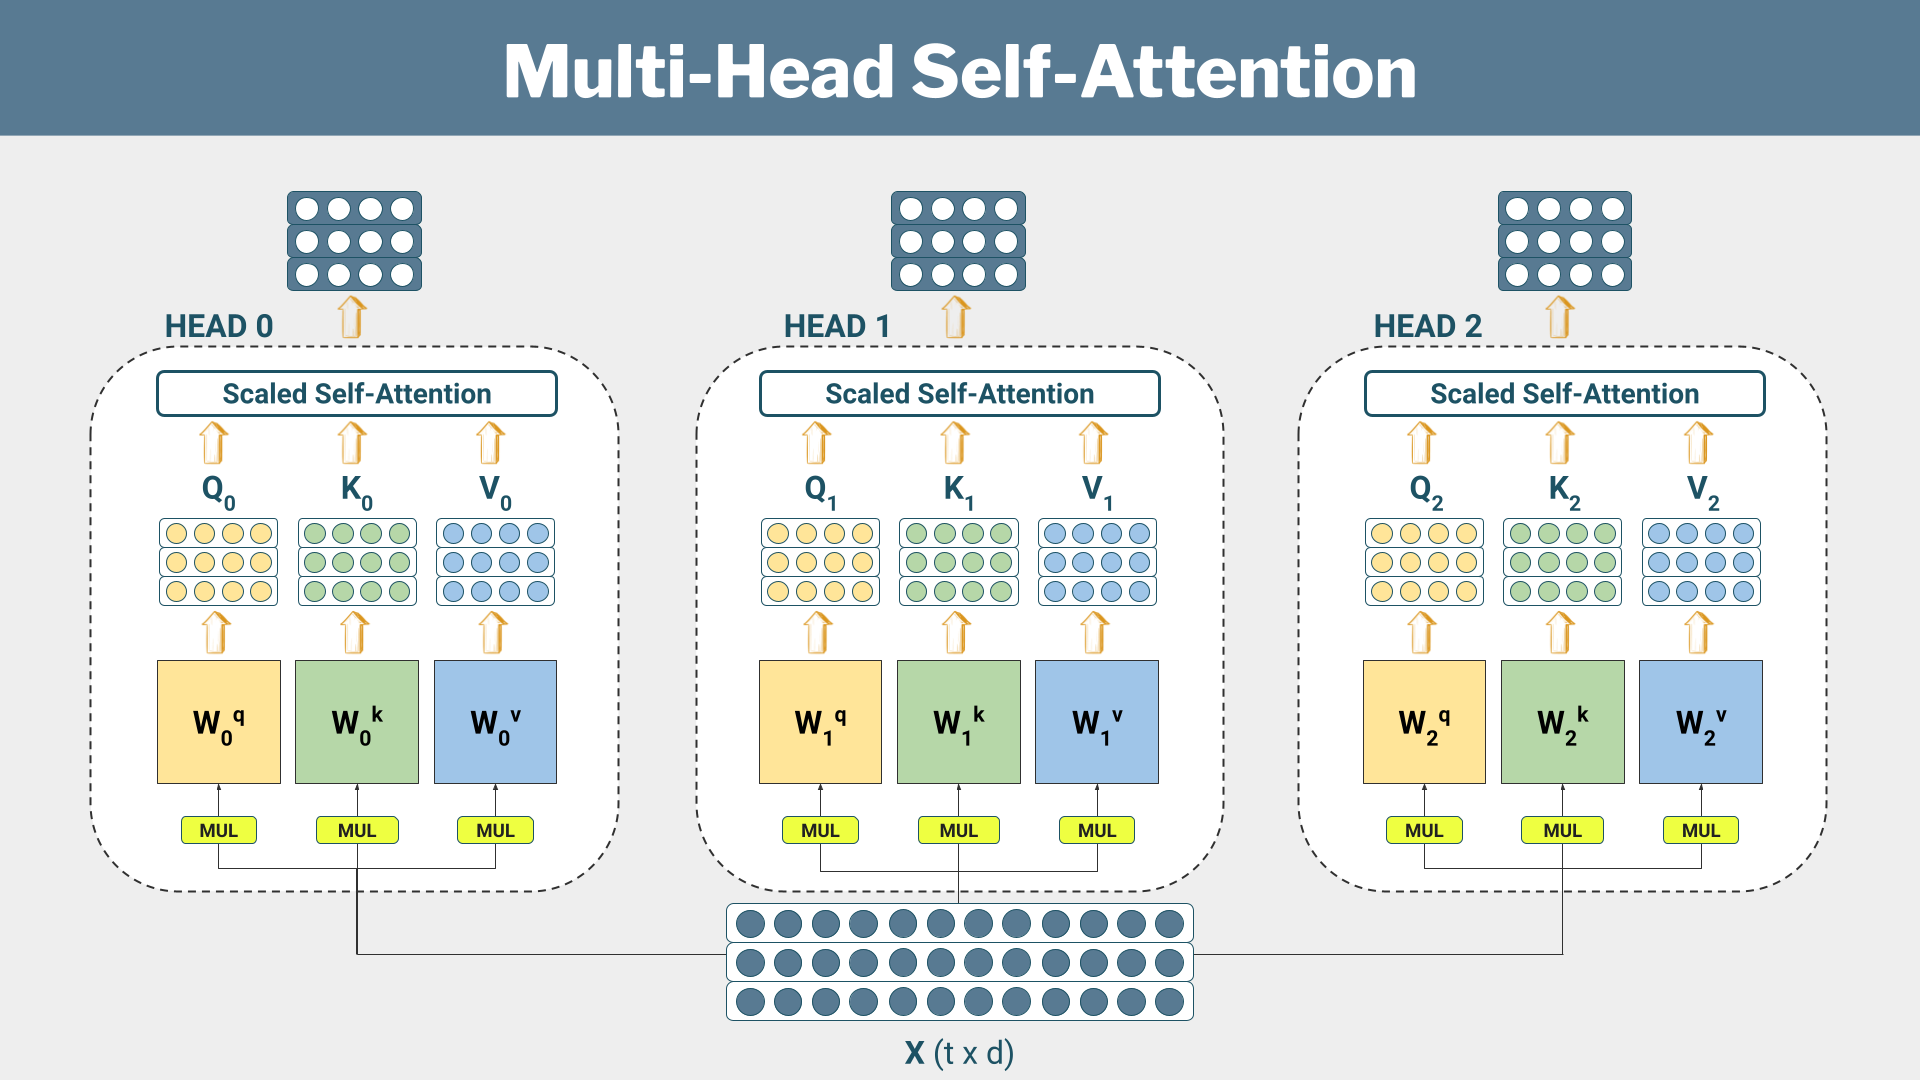

In [27]:
#show case of above code
batch_size = 1
seq_len = 3
embed_dim = 12
num_heads = 3
head_dim = embed_dim // num_heads

print(f"Dimension of each head: {head_dim}")

x = torch.rand(batch_size, seq_len, embed_dim).to(device)
print("Input shape: ", x.shape, "\n")
print("Input:\n", x)

# The query weights for each head.
wq0 = torch.rand(embed_dim, head_dim)
wq1 = torch.rand(embed_dim, head_dim)
wq2 = torch.rand(embed_dim, head_dim)

# The key weights for each head. 
wk0 = torch.rand(embed_dim, head_dim)
wk1 = torch.rand(embed_dim, head_dim)
wk2 = torch.rand(embed_dim, head_dim)

# The value weights for each head.
wv0 = torch.rand(embed_dim, head_dim)
wv1 = torch.rand(embed_dim, head_dim)
wv2 = torch.rand(embed_dim, head_dim)

print("The three sets of query weights (one for each head):")
print("wq0:\n", wq0)
print("wq1:\n", wq1)
print("wq2:\n", wq1)

# Geneated queries, keys, and values for the first head.
q0 = torch.matmul(x, wq0)
k0 = torch.matmul(x, wk0)
v0 = torch.matmul(x, wv0)

# Geneated queries, keys, and values for the second head.
q1 = torch.matmul(x, wq1)
k1 = torch.matmul(x, wk1)
v1 = torch.matmul(x, wv1)

# Geneated queries, keys, and values for the third head.
q2 = torch.matmul(x, wq2)
k2 = torch.matmul(x, wk2)
v2 = torch.matmul(x, wv2)

print("Q, K, and V for first head:\n")

print(f"q0 {q0.shape}:\n", q0, "\n")
print(f"k0 {k0.shape}:\n", k0, "\n")
print(f"v0 {v0.shape}:\n", v0)

out0, attn_weights0 = scaled_dot_product_attention(q0, k0, v0)

print("Output from first attention head: ", out0, "\n")
print("Attention weights from first head: ", attn_weights0)

out1, _ = scaled_dot_product_attention(q1, k1, v1)
out2, _ = scaled_dot_product_attention(q2, k2, v2)

print("Output from second attention head: ", out1, "\n")
print("Output from third attention head ", out2,)

combined_out_a = np.concatenate((out0, out1, out2), axis=-1)
print(f"Combined output from all heads {combined_out_a.shape}:")
print(combined_out_a)

Dimension of each head: 4
Input shape:  torch.Size([1, 3, 12]) 

Input:
 tensor([[[0.9840, 0.2142, 0.6173, 0.3639, 0.3119, 0.6577, 0.4740, 0.7553,
          0.4157, 0.7558, 0.7381, 0.5895],
         [0.0860, 0.0493, 0.1942, 0.7664, 0.1567, 0.8312, 0.1144, 0.3119,
          0.6679, 0.5610, 0.9938, 0.7864],
         [0.1143, 0.7462, 0.0964, 0.1930, 0.4111, 0.0549, 0.8526, 0.6404,
          0.7261, 0.7667, 0.2357, 0.4512]]], device='cuda:0')
The three sets of query weights (one for each head):
wq0:
 tensor([[0.7639, 0.3450, 0.6155, 0.5511],
        [0.2437, 0.6873, 0.6163, 0.2324],
        [0.8248, 0.7356, 0.0470, 0.0166],
        [0.8260, 0.6913, 0.6619, 0.1374],
        [0.5239, 0.5549, 0.7143, 0.5608],
        [0.2666, 0.3965, 0.7630, 0.0908],
        [0.9888, 0.2049, 0.6122, 0.6421],
        [0.6574, 0.5814, 0.7000, 0.7682],
        [0.9589, 0.3281, 0.7996, 0.4472],
        [0.0637, 0.7294, 0.9033, 0.3775],
        [0.1059, 0.2944, 0.1147, 0.9656],
        [0.6266, 0.7445, 0.1698, 0.4

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [28]:
#combine the above code with this
wq = torch.concatenate((wq0, wq1, wq2), axis=1)
wk = torch.concatenate((wk0, wk1, wk2), axis=1)
wv = torch.concatenate((wv0, wv1, wv2), axis=1)

print(f"Single query weight matrix {wq.shape}: \n", wq)
print(f"Single key weight matrix {wk.shape}:\n", wk, "\n")
print(f"Single value weight matrix {wv.shape}:\n", wv)

q_s = torch.matmul(x, wq)
k_s = torch.matmul(x, wk)
v_s = torch.matmul(x, wv)

print(f"Query vectors using a single weight matrix {q_s.shape}:\n", q_s)

#reshaping
q_s_reshaped = q_s.view(batch_size, seq_len, num_heads, head_dim)
print(f"Combined queries: {q_s.shape}\n", q_s, "\n")
print(f"Reshaped into separate heads: {q_s_reshaped.shape}\n", q_s_reshaped)

"""
looks like this but we want below, where the first box has rows split amoungst the rest
[[a, b, c][d, e, f][g, h, i]]
into
so this way each individual "batch" is seperated
[[a, d, g][b, e, h][c, f, i]]
"""

q_s_transposed = q_s_reshaped.permute(0, 2, 1, 3)
print(f"Queries transposed into \"separate\" heads {q_s_transposed.shape}:\n", 
      q_s_transposed)

# we see its same as before
print("The separate per-head query matrices from before: ")
print(q0, "\n")
print(q1, "\n")
print(q2)

k_s_transposed = (k_s.view(batch_size, -1, num_heads, head_dim)).permute(0, 2, 1, 3)
v_s_transposed = (v_s.view(batch_size, -1, num_heads, head_dim)).permute(0, 2, 1, 3)

print(f"Keys for all heads in a single matrix {k_s.shape}: \n", k_s_transposed, "\n")
print(f"Values for all heads in a single matrix {v_s.shape}: \n", v_s_transposed)


all_heads_output, all_attn_weights = scaled_dot_product_attention(q_s_transposed, 
                                                                  k_s_transposed, 
                                                                  v_s_transposed)
print("Self attention output:\n", all_heads_output)
#another sanity check to see that combined its same as before
print("Per head outputs from using separate sets of weights per head:")
print(out0, "\n")
print(out1, "\n")
print(out2)

#final concatenated result needs to reverse reshaping and transposing
combined_out_b = all_heads_output.permute(0, 2, 1, 3).reshape(batch_size, seq_len, embed_dim)


Single query weight matrix torch.Size([12, 12]): 
 tensor([[0.7639, 0.3450, 0.6155, 0.5511, 0.1391, 0.6558, 0.2475, 0.3267, 0.9481,
         0.8453, 0.0289, 0.2002],
        [0.2437, 0.6873, 0.6163, 0.2324, 0.4141, 0.4133, 0.6725, 0.5506, 0.5378,
         0.7141, 0.1737, 0.7866],
        [0.8248, 0.7356, 0.0470, 0.0166, 0.8994, 0.6836, 0.2803, 0.8527, 0.0701,
         0.3270, 0.6744, 0.3999],
        [0.8260, 0.6913, 0.6619, 0.1374, 0.5434, 0.9463, 0.8397, 0.9269, 0.0732,
         0.3700, 0.8621, 0.4719],
        [0.5239, 0.5549, 0.7143, 0.5608, 0.4670, 0.4711, 0.9982, 0.6586, 0.9605,
         0.6786, 0.1942, 0.2976],
        [0.2666, 0.3965, 0.7630, 0.0908, 0.7804, 0.4385, 0.6690, 0.0839, 0.0362,
         0.3628, 0.0236, 0.2990],
        [0.9888, 0.2049, 0.6122, 0.6421, 0.9669, 0.5076, 0.6070, 0.6329, 0.0718,
         0.5657, 0.3645, 0.2799],
        [0.6574, 0.5814, 0.7000, 0.7682, 0.3130, 0.1015, 0.6650, 0.2649, 0.1813,
         0.8918, 0.4145, 0.3378],
        [0.9589, 0.3281, 0.79

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [29]:
class multiHeadedSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(multiHeadedSelfAttention, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        
        self.head_size = hidden_size // num_heads
        
        self.Wq = nn.Linear(hidden_size, hidden_size)
        self.Wk = nn.Linear(hidden_size, hidden_size)
        self.Wv = nn.Linear(hidden_size, hidden_size)
        
        self.dense = nn.Linear(hidden_size, hidden_size)
    
    def splitHeads(self, x):
        batch_size, seq_len, _ = x.size()
        
        # gotta double check the sizes on this. im loosing track when its being trnasposed
        
        # (batch_size, seq_len, num_heads, head_size)
        x = x.view(batch_size, seq_len, self.num_heads, self.head_size)
        # (batch_size, num_heads, seq_len, head_size)
        return x.permute(0, 2, 1, 3)
        
        
    def mergeHeads(self, x):
        x = x.permute(0, 2, 1, 3)
        batch_size, seq_len, _, scaryBro= x.size()
        
        # gotta double check the sizes on this. im loosing track when its being trnaspose
        
        
        # (batch_size, seq_len, hidden_size)
        # also condigiuoguious wibbly wobbly wibbly wobbly woahah
        return x.contiguous().view(batch_size, seq_len, self.hidden_size)
    
    def forward(self, q, k, v, mask=None):
        qs = self.Wq(q)
        ks = self.Wk(k) 
        vs = self.Wv(v)

        qs = self.splitHeads(qs)
        ks = self.splitHeads(ks)
        vs = self.splitHeads(vs)

        output, attn_weights = scaled_dot_product_attention(qs, ks, vs, mask)
        output = self.mergeHeads(output)

        # ok also kinda confused aobut if the shapes after merge is already B, L, Hidden
        # whats the purpose of the dense layer only to get it back to B, L, Hidden
        # ok jk again it learns whats important from each self attention head
        return self.dense(output), attn_weights
        

In [33]:
mhsa = multiHeadedSelfAttention(12, 3).to(device)

output, attn_weights = mhsa(x, x, x, None)
print(f"MHSA output{output.shape}:")
print(output)

MHSA outputtorch.Size([1, 3, 12]):
tensor([[[ 0.0808,  0.2158,  0.0115, -0.4729,  0.0267, -0.0038,  0.4965,
           0.2366, -0.2089,  0.2716,  0.2950, -0.2594],
         [ 0.0820,  0.2164,  0.0096, -0.4738,  0.0289, -0.0064,  0.4975,
           0.2357, -0.2084,  0.2732,  0.2945, -0.2564],
         [ 0.0780,  0.2172,  0.0109, -0.4745,  0.0282, -0.0059,  0.4969,
           0.2378, -0.2101,  0.2724,  0.2955, -0.2566]]], device='cuda:0',
       grad_fn=<ViewBackward0>)


In [34]:
def feedFoward(hidden_size, double_size):
    return nn.Sequential(
        nn.Linear(hidden_size, double_size),
        nn.ReLU(),
        nn.Linear(double_size, hidden_size)
    )

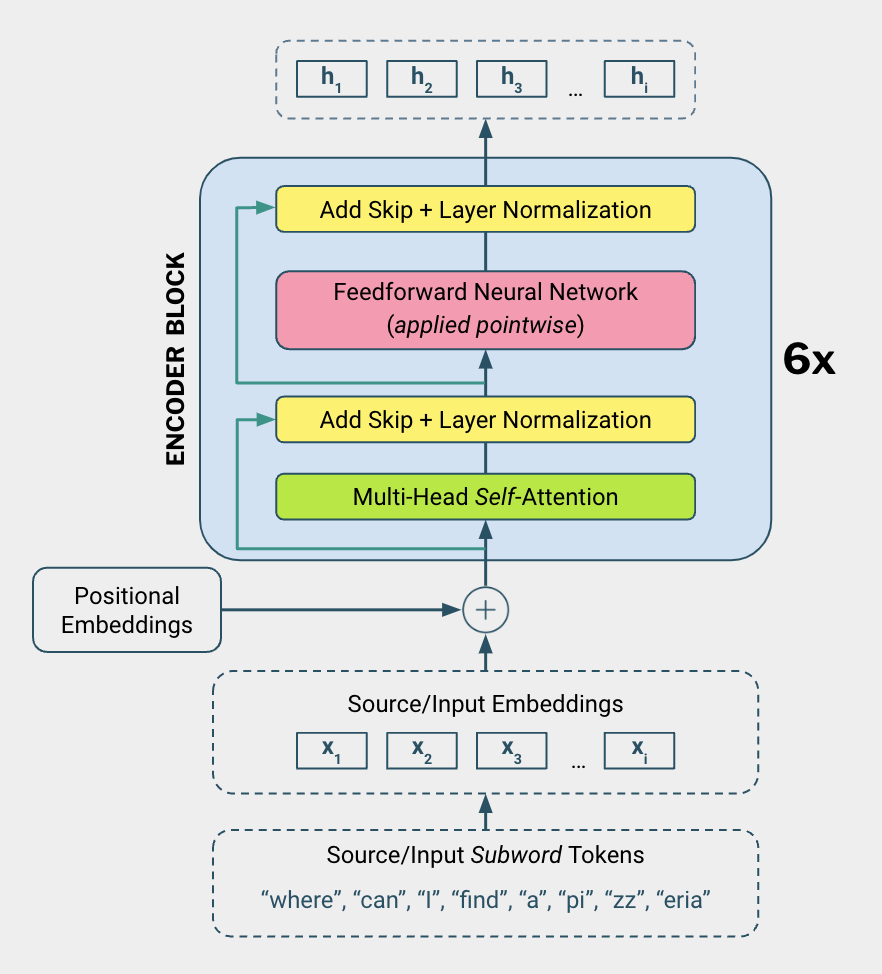

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, double_size, dropout=0.1):
        super(EncoderBlock, self).__init__()
        
        self.mhsa = multiHeadedSelfAttention(hidden_size, num_heads)
        self.ff15 = feedFoward(hidden_size, double_size)
        
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layerNorm1 = nn.LayerNorm(hidden_size)
        self.layerNorm2 = nn.LayerNorm(hidden_size)
        
    def forward(self, x, mask=None):
        
        #trying out pre instead of post norm
        x = self.layerNorm1(x)
        output, hidden = self.mhsa(x, x, x, mask)
        x = x + self.dropout1(output)
        
    
        x = self.layerNorm2(x)
        output = self.ff15(x)
        x = x + self.dropout2(output)
    
        return x, hidden
        
        

In [35]:
encoder_block = EncoderBlock(12, 3, 48).to(device)

block_output,  _ = encoder_block(x, None)
print(f"Output from single encoder block {block_output.shape}:")
print(block_output)

Output from single encoder block torch.Size([1, 3, 12]):
tensor([[[ 2.2403e+00, -1.2045e+00,  2.9267e-01, -5.8649e-01, -1.0242e+00,
           2.9903e-01, -8.2850e-01,  7.0537e-01, -1.5973e+00,  5.2038e-01,
           9.2197e-01, -1.5618e-01],
         [-1.1470e+00, -1.4416e+00, -1.2598e+00,  1.1275e+00, -1.1099e+00,
           1.2192e+00, -1.0455e+00, -3.8181e-01,  1.3229e-03,  1.7278e-01,
           2.2820e+00,  9.2965e-01],
         [-8.9279e-01,  6.8817e-01, -1.0289e+00, -8.5414e-01,  9.6358e-02,
          -1.8656e+00,  1.7051e+00,  1.3875e+00, -3.1813e-02,  1.5303e+00,
          -1.0149e+00, -3.4333e-01]]], device='cuda:0', grad_fn=<AddBackward0>)


In [13]:
from bpemb import BPEmb
bpemb_en = BPEmb(
    lang="en",
    vs=10000,
    dim=100,
    cache_dir="data",
    model_file="data/bpemb.model",
    emb_file="data/bpemb_vectors.txt"
)

In [14]:
bpemb_en.vectors[bpemb_en.words.index('car')]
bpemb_vocab_size, bpemb_embed_size = bpemb_en.vectors.shape

In [40]:
sample_sentence = "Where can I find a pizzeria?"
tokens = bpemb_en.encode(sample_sentence)
print(tokens)
#this lowkey cool
token_seq = torch.tensor(bpemb_en.encode_ids("Where can I find a pizzeria?")).to(device)
print(token_seq)

['▁where', '▁can', '▁i', '▁find', '▁a', '▁p', 'iz', 'zer', 'ia', '?']
tensor([ 571,  280,  386, 1934,    4,   24,  248, 4339,  177, 9967],
       device='cuda:0')


In [42]:
token_embedding = nn.Embedding(bpemb_vocab_size, embed_dim).to(device)
token_embeddings = token_embedding(token_seq)

# The untrained embeddings for our sample sentence.
print("Embeddings for: ", sample_sentence)
print(token_embeddings)

Embeddings for:  Where can I find a pizzeria?
tensor([[ 1.6558e-01, -5.2042e-02,  1.2750e+00, -3.9262e-01,  4.9188e-01,
         -1.7795e-02,  1.1828e+00, -2.2663e-01,  3.1991e-01, -2.2639e-01,
          1.0178e+00, -2.2351e+00],
        [-2.4528e+00, -3.4109e-01, -1.9152e+00, -3.1282e-01, -6.1806e-01,
         -7.3405e-01,  5.6785e-02, -1.6735e-01, -1.2041e-01, -6.4377e-01,
         -8.8359e-01, -8.6513e-02],
        [ 1.6554e+00, -1.0716e+00, -4.9817e-01,  2.0334e+00,  6.2191e-01,
         -1.0298e+00,  1.3217e-01, -9.0595e-01, -4.4795e-02,  3.9842e-01,
         -8.1364e-01,  7.0200e-01],
        [-6.5311e-02,  1.2060e+00,  5.2082e-01,  4.7299e-01, -1.5745e-01,
         -5.3064e-01, -1.5897e+00,  1.2928e-01, -1.8820e-01,  1.4240e+00,
          3.8891e-01,  6.7329e-01],
        [-1.3152e-01,  3.7110e-01,  3.7809e-01,  3.8576e-01,  1.1337e+00,
          1.0290e+00,  1.9008e+00,  1.0405e-01,  3.0903e-01,  4.2093e-01,
         -2.9364e-01,  2.0376e+00],
        [-2.3153e+00,  1.6629e+00,

In [45]:
#positional information now
max_seq_len = 256
position_embedding = nn.Embedding(max_seq_len, embed_dim).to(device)

pos_idx = torch.tensor(list(range(len(token_seq)))).to(device)
print(pos_idx)

position_embeddings = position_embedding(pos_idx)
print("Embeddings for: ", sample_sentence)
print(position_embeddings)

input = position_embeddings + token_embeddings

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')
Embeddings for:  Where can I find a pizzeria?
tensor([[ 0.3191, -0.1315,  0.1063,  0.4842, -0.8262, -1.2177,  1.0582,  0.8518,
          0.0720, -1.5424,  0.2017, -0.7926],
        [ 1.4372,  0.0238, -0.4902, -1.0538,  1.2061, -1.0647, -0.6986, -0.3746,
         -0.0607,  0.7602,  0.1435,  0.2354],
        [-0.1990,  0.1606,  0.6760,  0.9470,  0.3352,  0.9623,  0.0841, -0.8169,
         -0.5685,  1.6193,  0.9577,  1.0341],
        [ 0.7537,  0.7582, -0.6785, -1.4340, -1.0528, -1.4747, -1.5137,  0.2591,
         -0.0442, -1.0226,  0.1487,  1.2010],
        [-1.4699, -0.1920,  0.5822,  1.0915, -0.7267, -0.2631,  0.3623,  2.1108,
          1.5756,  1.0958, -0.4987,  0.1010],
        [-0.2222,  0.3108,  1.7715, -0.9655,  1.8716,  1.8561, -0.7140,  0.4331,
          1.0382,  1.3732, -0.2306, -1.4169],
        [ 1.1234, -0.0505,  0.4678, -0.7116, -0.3805,  0.0892, -0.2754, -0.6354,
         -1.0928,  1.5018, -0.6663, -0.0441],
        [

In [50]:
class Encoder(nn.Module):
    def __init__(self, num_blocks, hidden_size, num_heads, double_size, vocab_size, max_seq_len, dropout_rate=0.1):
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.max_seq_len = max_seq_len

        self.token_embedding = nn.Embedding(vocab_size, hidden_size)
        self.position_embedding = nn.Embedding(max_seq_len, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)

        self.blocks = nn.ModuleList([EncoderBlock(hidden_size, num_heads, double_size, dropout_rate) for _ in range(num_blocks)])
    
    def forward(self, input, mask):
        token_embeddings = self.token_embedding(input)
        
        total_positions = input.shape[0] * input.shape[1] #batch * length
        positions = torch.arange(total_positions).to(device)
        # goes from [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] if max is 5 to [0, 1, 2, 3, 4, 0, 1, 2, 3, 4]
        positions = positions.remainder(self.max_seq_len)
        positions = positions.view(input.shape[0], input.shape[1])
        position_embeddings = self.position_embedding(positions)
        
        x = self.dropout(token_embeddings + position_embeddings)

        for block in self.blocks:
            x, weights = block(x, mask)

        return x, weights

In [51]:
import itertools

PAD_token = 0
def zeroPadding(input, fillvalue=PAD_token):
    max_len = max(len(seq) for seq in input)
    return [seq + [fillvalue] * (max_len - len(seq)) for seq in input]

def binaryMatrix(input, value=PAD_token):
    m = []
    for i, seq in enumerate(input):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

#unsqueezes mask so that it fits with multiheaded attention of shape Batch, NumHeads, seqLen, seqLen
def inputVar(input):
    indexes_batch = [bpemb_en.encode_ids(sentence) for sentence in input]
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return padVar, mask

def outputVar(input):
    indexes_batch = [bpemb_en.encode_ids(sentence) for sentence in input]
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return padVar, mask

In [52]:
input_batch = [
    "Where can I find a pizzeria?",
    "Mass hysteria over listeria.",
    "I ain't no circle back girl."
]

input, mask = inputVar(input_batch)

In [ ]:
"""
skip, is just sanity test (i did not get sane)

#encoder test
num_encoder_blocks = 6

hidden_size = 300

num_heads = 3

double_size = 600

vocab_size = bpemb_vocab_size
max_input_seq_len = input.shape[1]
encoder = Encoder(num_encoder_blocks, hidden_size, num_heads, double_size, vocab_size, max_input_seq_len).to(device)
encoder.zero_grad()
input = input.to(device)
mask = mask.to(device)
encoder_output, attn_weights = encoder(input, mask)
print(f"Encoder output {encoder_output.shape}:")
print(encoder_output)"""

Encoder output torch.Size([3, 10, 300]):
tensor([[[ 5.5651e-01, -2.4218e-01,  3.7521e-01,  ...,  1.5457e+00,
           2.0887e+00,  1.3734e+00],
         [ 8.0613e-01, -1.0393e-01, -1.0491e+00,  ..., -6.1457e-01,
          -1.0205e+00, -8.2368e-01],
         [ 7.1982e-01, -1.2229e+00, -1.3716e+00,  ...,  5.2581e-01,
           8.7080e-01, -5.3143e-02],
         ...,
         [ 2.1255e+00, -1.5738e+00,  3.6623e-01,  ..., -2.6650e-01,
           1.0129e+00,  3.5004e-02],
         [-6.5186e-01, -4.9791e-01, -1.6869e+00,  ...,  1.6277e-01,
          -2.5074e-01, -1.3165e+00],
         [-1.5357e+00, -8.2525e-01, -8.3553e-01,  ...,  7.1817e-01,
           2.6269e+00, -5.3841e-01]],

        [[ 1.0132e+00, -4.1088e-01, -1.2458e-01,  ...,  6.0898e-01,
           1.2248e+00,  4.4283e-01],
         [ 2.1218e-01, -8.6542e-01, -2.1775e-03,  ..., -5.9950e-01,
           1.3503e+00, -1.4683e+00],
         [ 6.1566e-01, -3.8835e-01, -1.0461e+00,  ..., -7.7590e-01,
           6.9798e-01,  9.9886e-01]